# Usage of the robustness check on DiCE

NOTE IN THIS DATASET, CLASS "BAD" IS TOGGLED. IN THE PROCESSED DATASET, "BAD"==1 MEANS GOOD.

The PyTorch model's training and incremental training procedures are implemented to mimic those of sklearn models, which we have used in other experiments.

In [13]:
import time
import os, sys, pickle, json, math, time, multiprocessing, warnings, itertools, random, warnings, gc, ast, subprocess
import copy
from collections import defaultdict, Counter, namedtuple
from math import log
from itertools import product, combinations
from random import choice, choices, sample, seed
from datetime import datetime

import gurobipy
from sklearn.metrics.pairwise import euclidean_distances
from importlib import reload
# Basics
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Multi-processing
from joblib import Parallel, delayed
from tqdm import tqdm

# sci-kit learn
import sklearn
import sklearn.datasets as datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from utilexp import *

pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

import warnings

warnings.filterwarnings('ignore')
from expnns.preprocessor import Preprocessor, min_max_scale


In [2]:
# load dataset
df = pd.read_csv("../datasets/heloc/hmeq.csv", delimiter=',')
continuous_features = ["LOAN", "MORTDUE", "VALUE", "YOJ", "DEROG", "DELINQ", "CLAGE", "NINQ", "CLNO",
                       "DEBTINC"]
df = df.drop(columns=["REASON", "JOB"])
df = df.dropna()

dfx, dfy = df.drop(columns=['BAD']), pd.DataFrame(df['BAD'])
df = pd.concat([dfx, dfy], axis=1)
display(df)
# min max scale
min_vals = np.min(df[continuous_features], axis=0)
max_vals = np.max(df[continuous_features], axis=0)
df_mm = min_max_scale(df, continuous_features, min_vals, max_vals)

# get X, y
X, y = df_mm.drop(columns=['BAD']), pd.DataFrame(1 - df_mm['BAD'])
df1 = df_mm[:1757]
SPLIT = .2
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=SPLIT, shuffle=True,
                                                    random_state=0)

ordinal_features = {}
discrete_features = {}
columns = list(df_mm.columns)
feat_var_map = {}
for i in range(len(X.columns)):
    feat_var_map[i] = [i]


,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,BAD
5,1700,30548.0,40320.0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,1
7,1800,28502.0,43034.0,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894,1
19,2300,102370.0,120953.0,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503,0
25,2400,34863.0,47471.0,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601,1
26,2400,98449.0,117195.0,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827,0
...,...,...,...,...,...,...,...,...,...,...,...
5955,88900,57264.0,90185.0,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,0
5956,89000,54576.0,92937.0,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,0
5957,89200,54045.0,92924.0,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,0
5958,89800,50370.0,91861.0,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,0


In [3]:
min_vals = np.array(min_vals)
max_vals = np.array(max_vals)


def inverse_min_max_scale(xm):
    return (max_vals - min_vals) * xm + min_vals

In [4]:
X1, X2 = X[:1757], X[1757:]
y1, y2 = y[:1757], y[1757:]
SPLIT = .2
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, stratify=y1, test_size=SPLIT, shuffle=True,
                                                        random_state=0)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, stratify=y2, test_size=SPLIT, shuffle=True,
                                                        random_state=0)

In [5]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
from utilexp import *

Using cuda device


In [6]:
from torch.utils.data import DataLoader, Dataset

class DemoDataset(Dataset):
    def __init__(self, X, y):
        try:
            self.X = X.values
            self.y = y.values
        except:
            self.X = X
            self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.y[idx]),float()

In [85]:
# model using Sequential()
"""
trainds = DemoDataset(X1_train, y1_train)
testds = DemoDataset(X1_test, y1_test)
params = {'batch_size': 32,
          'shuffle': True}
traindl = DataLoader(trainds, **params)
testdl = DataLoader(testds, **params)

model = torch.nn.Sequential(
    torch.nn.Linear(10, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 1),
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
epochs = 100
l2lamb = 0.0001
for ep in range(epochs):
    for (Xb, yb, _) in traindl:
        model.train()
        optimizer.zero_grad()
        y1_pred = model(torch.tensor(Xb).float())
        loss_pred = loss_fn(y1_pred, torch.tensor(yb).float())
        l2_norm = sum(val.pow(2.0).sum() for val in model.parameters())
        loss = loss_pred + l2lamb * l2_norm
        print('Epoch {}: train loss: {}'.format(ep, loss.item()))
        loss.backward()
        optimizer.step()
        """

Epoch 0: train loss: 0.7561066150665283
Epoch 0: train loss: 0.7125176191329956
Epoch 0: train loss: 0.6799675226211548
Epoch 0: train loss: 0.6465974450111389
Epoch 0: train loss: 0.6300753951072693
Epoch 0: train loss: 0.5903058052062988
Epoch 0: train loss: 0.5498446822166443
Epoch 0: train loss: 0.5088981986045837
Epoch 0: train loss: 0.5646379590034485
Epoch 0: train loss: 0.4966583251953125
Epoch 0: train loss: 0.4678831696510315
Epoch 0: train loss: 0.48069459199905396
Epoch 0: train loss: 0.48219943046569824
Epoch 0: train loss: 0.5006915926933289
Epoch 0: train loss: 0.49810290336608887
Epoch 0: train loss: 0.39517197012901306
Epoch 0: train loss: 0.3428173363208771
Epoch 0: train loss: 0.3995702266693115
Epoch 0: train loss: 0.38834312558174133
Epoch 0: train loss: 0.4172157645225525
Epoch 0: train loss: 0.3714316189289093
Epoch 0: train loss: 0.34066081047058105
Epoch 0: train loss: 0.26017943024635315
Epoch 0: train loss: 0.37134549021720886
Epoch 0: train loss: 0.448483407

In [126]:
#torch.save(model, "./dice_demo_same_setting_as_sklearn.pth")

In [27]:
model = torch.load("./dice_demo_same_setting_as_sklearn.pth")

In [28]:
resres = model(torch.tensor(X1_train.values).float()).detach().numpy().flatten().round()
print('\n', classification_report(y1_train, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))
resres = model(torch.tensor(X1_test.values).float()).detach().numpy().flatten().round()
print('\n', classification_report(y1_test, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))
resres = model(torch.tensor(X.values).float()).detach().numpy().flatten().round()
print('\n', classification_report(y, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))



                  precision    recall  f1-score   support

 bad credit (0)      0.812     0.194     0.313       134
good credit (1)      0.921     0.995     0.957      1271

       accuracy                          0.919      1405
      macro avg      0.867     0.595     0.635      1405
   weighted avg      0.911     0.919     0.895      1405


                  precision    recall  f1-score   support

 bad credit (0)      0.750     0.176     0.286        34
good credit (1)      0.919     0.994     0.955       318

       accuracy                          0.915       352
      macro avg      0.834     0.585     0.620       352
   weighted avg      0.902     0.915     0.890       352


                  precision    recall  f1-score   support

 bad credit (0)      0.849     0.201     0.325       309
good credit (1)      0.928     0.997     0.961      3206

       accuracy                          0.927      3515
      macro avg      0.889     0.599     0.643      3515
   weighted avg  

In [29]:
# wrapper class of pytorch models
class CLF(object):
    def __init__(self, model, hidden_layer_sizes=5, n_features_in=10):
        self.model = copy.deepcopy(model)
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_features_in_ = n_features_in
        self.coefs_, self.intercepts_ = self.get_params()

    # take in [n_samples, n_features] array, return a numpy arr
    def predict(self, x):
        yhats = None
        try:
            yhats = self.model(torch.tensor(x).float()).detach().numpy().flatten().round().astype(np.int64)
        except:
            yhats = self.model(torch.tensor(x.values).float()).detach().numpy().flatten().round().astype(np.int64)
        return yhats

    def predict_proba(self, x):
        self.model.eval()
        yhats = None
        try:
            yhats = self.model(torch.tensor(x).float()).detach().numpy().flatten().astype(np.float64)
        except:
            yhats = self.model(torch.tensor(x.values).float()).detach().numpy().flatten().astype(np.float64)
        yreturn = []
        for this_proba in yhats:
            yreturn.append([1 - this_proba, this_proba])
        return np.array(yreturn)

    def partial_fit(self, Xdf, ydf, targets=None):
        trainds1 = DemoDataset(Xdf, ydf)
        params = {'batch_size': 8,
          'shuffle': True}
        traindl1 = DataLoader(trainds1, **params)
        #if isinstance(Xdf, pd.core.frame.DataFrame):
        #    Xt = Xdf.values
        #else:
        #    Xt = Xdf
        #if isinstance(ydf, pd.core.frame.DataFrame):
        #    yt = ydf.values
        #else:
        #    yt = ydf
        loss_fn = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.02)
        epochs = 1
        l2lamb = 0.0001
        for ep in range(epochs):
            for (Xb, yb, _) in traindl1:
                self.model.train()
                optimizer.zero_grad()
                yp = self.model(torch.tensor(Xb).float())
                loss_pred = loss_fn(yp, torch.tensor(yb).float())
                #print('Epoch {}: train loss: {}'.format(ep, loss.item()))
                l2_norm = sum(val.pow(2.0).sum() for val in self.model.parameters())
                loss = loss_pred + l2lamb * l2_norm
                loss.backward()
                optimizer.step()
        # update params
        self.coefs_, self.intercepts_ = self.get_params()

    def get_params(self):
        w1 = None
        w2 = None
        b1 = None
        b2 = None
        for i, item in enumerate(self.model.parameters()):
            if i == 0:
                w1 = item.data.detach().numpy()
            if i == 1:
                b1 = item.data.detach().numpy()
            if i == 2:
                w2 = item.data.detach().numpy()
            if i == 3:
                b2 = item.data.detach().numpy()
        w1 = w1.transpose()
        w2 = w2.transpose()
        b1 = b1
        return [w1, w2], [b1, b2]


In [30]:
clf = CLF(model)

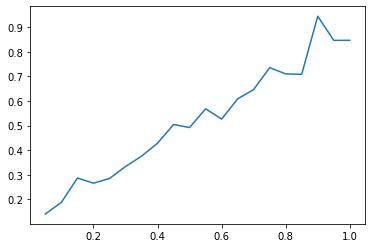

In [31]:
gaps = np.arange(0.05, 1.01, 0.05)
deltas = []
clfs = []
for a, i in enumerate(gaps):
    clfs.append(copy.deepcopy(clf))
    util_exp = UtilExp(clfs[a], X1, y1, X2, y2, columns, ordinal_features, discrete_features, continuous_features, feat_var_map,
                   num_test_instances=1000, gap=i)
    deltas.append(util_exp.delta_min)
plt.plot(gaps, deltas)

In [32]:
util_exp = UtilExp(clf, X1, y1, X2, y2, columns, ordinal_features, discrete_features, continuous_features, feat_var_map,
                   num_test_instances=1000, gap=0.03)

In [33]:
#print(util_exp.delta_max)
#print(util_exp.delta_min)
util_exp.delta_min = 0.12069
util_exp.build_inns()
print(util_exp.delta_min)

0.12069


In [34]:
print(deltas)
deltas_to_plot = [0, util_exp.delta_min, deltas[1], deltas[3], deltas[6], deltas[9], deltas[14],deltas[19]]
# 0%, 3%(sound), 10%, 20%, 35%, 50%, 75%, 100%

[0.1412121, 0.18835211, 0.2869272, 0.2660073, 0.28493905, 0.3337103, 0.37567338, 0.42845416, 0.5041746, 0.49200004, 0.56798464, 0.5263237, 0.6083286, 0.6462892, 0.7352086, 0.70953023, 0.70821565, 0.9438548, 0.84585196, 0.8460502]


In [35]:
valids = util_exp.verify_soundness()
print(len(valids))
print(valids)

percentage of sound model changes: 0.125
5
[11, 19, 22, 26, 30]


In [36]:
util_exp.test_instances = util_exp.test_instances[valids]
print(len(util_exp.test_instances))

5


In [37]:
# DiCE imports
import dice_ml
from dice_ml import Dice

In [38]:
d = dice_ml.Data(dataframe=df1, continuous_features=X.columns.to_list(), outcome_name="BAD")
m = dice_ml.Model(model=model, backend="PYT")
exp = Dice(d, m)

In [39]:
# generate cfs
xs = util_exp.test_instances
cfs = []
for i, x in enumerate(xs):
    cf = exp.generate_counterfactuals(pd.DataFrame(x.reshape(1, -1), columns=X1.columns), total_CFs=20,
                                  desired_class=1, proximity_weight=0.05, diversity_weight=1)
    cfs.append(cf.cf_examples_list[0].final_cfs_df.drop(columns=["BAD"]).values)

Diverse Counterfactuals found! total time taken: 00 min 20 sec


Diverse Counterfactuals found! total time taken: 00 min 21 sec


Diverse Counterfactuals found! total time taken: 00 min 17 sec


Diverse Counterfactuals found! total time taken: 00 min 18 sec
Diverse Counterfactuals found! total time taken: 00 min 19 sec


In [40]:
#deltas_to_plot = [0] + deltas[:9]
deltas_validities = []
y_prime = 1
for delta in deltas_to_plot:
    delta_val = 0
    nodes = build_inn_nodes(util_exp.clf, util_exp.num_layers)
    weights, biases = build_inn_weights_biases(util_exp.clf, util_exp.num_layers, delta, nodes)
    inn_delta = Inn(util_exp.num_layers, delta, nodes, weights, biases)
    for i, x in enumerate(xs):
        for this_cf in cfs[i]:
            this_solver = OptSolver(util_exp.dataset, inn_delta, y_prime, x, mode=1, M=10000, x_prime=this_cf)
            if this_solver.compute_inn_bounds()[0] == 1:
                delta_val += 1
    deltas_validities.append(delta_val)

In [41]:
print(deltas_validities)

[73, 46, 35, 22, 9, 1, 0, 0]


In [42]:
xticks_names = ["$\delta$=0 (0%)", "$\delta$-3%(sound)", "$\delta$-10%", "$\delta$-20%", "$\delta$-35%", "$\delta$-50%", "$\delta$-75%", "$\delta$-100%"]
xticks_names = ["$\delta$=0 (0%)", "$\delta$=0.12 (3%, sound)", "$\delta$=0.22 (10%)", "$\delta$=0.37 (20%)", "$\delta$=0.43 (35%)", "$\delta$=0.48 (50%)", "$\delta$=0.67 (75%)", "$\delta$=0.77 (100%)"]
xticks_names = ["0, 0%", "0.12, 3% (sound)", "0.22, 10%", "0.37, 20%", "0.43, 35%", "0.48, 50%", "0.67, 75%", "0.77, 100%"]

In [43]:
print(deltas_to_plot)

[0, 0.12069, 0.18835211, 0.2660073, 0.37567338, 0.49200004, 0.7352086, 0.8460502]


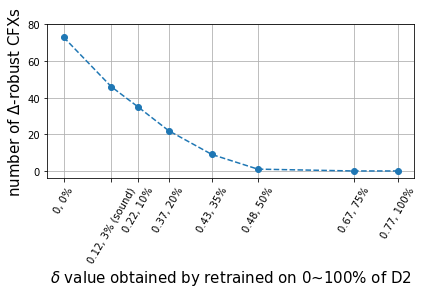

In [47]:
fig, ax = plt.subplots()
ax.plot(deltas_to_plot, deltas_validities, "o--")
ax.set_xticks(deltas_to_plot)
ax.set_xticklabels(xticks_names)
ax.grid()
ax.set_yticks(np.arange(0, 100, 20))
ax.set_ylabel("number of $\Delta$-robust CFXs", fontsize=15)
ax.set_xlabel("$\delta$ value obtained by retrained on 0~100% of D2", fontsize=15)
plt.xticks(rotation=60)
fig.tight_layout()
fig.savefig("./plots/DiCE-Demo.png", dpi=300)
